# Extremos climáticos

Este cuaderno de jupyter está dedicado al análisis de eventos extremos.

En las primeras celdas cargaremos los módulos necesarios para todo el cuaderno y 
definiremos las funciones que se emplearán a lo largo del cuaderno.

### Módulos y paquetes que emplearemos

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from scipy import stats 
from scipy import optimize as op

### Funciones que usaremos:

In [1]:
def nor(mu,sigma,x):
    #Nota: también podrías usar la función norm.pdf(x,k) del módulo stats del paquete scipy
    N=1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * sigma**2))
    return N

def GEV(x,c):
    #Función que calcula la función densidad de probabilidad de Generalized Extrem Value normalizada
    # con m = 0, s = 1
    #nota: también puedes usar g=stats.genextreme.pdf(x,-c)
    if ( abs(c) < 0.005 ) :
        g = np.exp(-np.exp(-x))*np.exp(-x)
    else:
        g = ( np.power( 1 + c * x , -1-1/c) ) * np.exp( - np.power(1 + c * x ,-1/c) )
    return g

def GEVms(x,c,m,s):
    #Función que calcula la función de densidad de probabilidad Generalizada Extreme Value sin normalizar
    y = ( x - m ) / s
    if ( abs(c) < 0.005 ) :
        g = ( np.exp(-np.exp(-y))*np.exp(-y) ) / s
    else:
        g = ( np.power( 1 + c * y , -1-1/c) ) * np.exp( - np.power(1 + c * y ,-1/c) ) / s
    return g

def GPDs(y,c,s):
    #Función que calcula la función de densidad de probabilidad de Pareto Generalizada 
    if (abs(c)<0.0001):
        h = np.exp(-y/s)*(1/s)
    else:
        h = (1/s) * ( 1 + c * y / s) ** (-1-1/c)
    h[y<=0]=0
    return h

def MLE_GEV(c,m,s,x):
    #Función que calcula la función likelihood sobre GEV con 
    #los parámetros de entrada c,m,s
    #y la muestra de datos x
    if ( (s < 0) | np.any(1 + c * (x-m)/s ) < 0):
        sal=1e7
    else:            
        if (abs(c) > 0.00001 ):
            t = (1 + c * (x-m)/s )**(-1/c)
        else :
            t = np.exp(-(x-m)/s)
        f = - np.log(s) + (c +1)*np.log(t) -t
        sal = f.sum()
    return -sal


def returnLevel(p, c,m,s):
    if (abs(c) > 0.00001 ):
        zp = m - ( s / c ) * ( 1 - ( - np.log( 1 - p ) ) ** ( - c ))
    else :
        zp = m - s * np.log( - np.log( 1 - p ) )
    return zp


def densityPlotGEV(ax,x,c,m,s):
    n, bins, dummy = ax.hist(x,density=True,label='Empirica')
    x1, x2 = 2*bins[0] - bins[1], 2* bins[-1] - bins[-2]
    ax.set_xlim(x1,x2)
    x_x = np.linspace(x1,x2,200)
    y_y = GEVms(x_x,c,m,s)
    ax.plot(x_x,y_y,'r',label='Ajuste')
    ax.legend()
    ax.grid()
    ax.set_ylabel('probabilidad f(z)')
    ax.set_xlabel('z')
    return

def probabilityPlot(ax,pExp,pTeor):
    ax.plot([0,1],[0,1])
    ax.plot(pExp,pTeor,'o')
    ax.set_ylabel('Model')
    ax.set_xlabel('Empirical')
    ax.set_title('Probability plot')
    ax.grid()
    return

def quantilePlot(ax,xTeor,xSort):
    ax.plot([xSort[0],xSort[-1]],[xSort[0],xSort[-1]])
    ax.plot(xTeor,xSort,'o')
    ax.set_ylabel('Model')
    ax.set_xlabel('Empirical')
    ax.set_title('Quantile plot')
    ax.grid()
    return

def returnPlot(ax,p,zp,pExp,xSort):
    ax.semilogx(1/p,zp)
    ax.grid()
    ax.set_xlim(1e-1,1e3)
    ax.semilogx(1/pExp,xSort,'o')
    ax.set_title('Return level plot')
    ax.set_xlabel('Return period (years)')
    ax.set_ylabel('Return level')
    return
    
def diagnosticsGEV(x,c,m,s):
    y = (x-m)/s
    ySort = np.sort(y)
    pExp = np.arange(1,ySort.size+1,1)/(ySort.size+1)
    pTeor = stats.genextreme.cdf(ySort,-c)
    xSort = np.sort(x)
    pExp = np.arange(1,xSort.size+1,1)/(xSort.size+1)
    pExpinv = np.arange(xSort.size+1,1,-1)/(xSort.size+1)
    xTeor = returnLevel(1-pExp, c,m,s)    
    p = np.logspace(-2, -1e-2, 100)
    zp=returnLevel(p,c,m,s)
    fig, ax = plt.subplots(2, 2, figsize=(14,10))
    probabilityPlot(ax[0,0],pExp,pTeor)
    quantilePlot(ax[0,1],xTeor,xSort)
    returnPlot(ax[1,0],p,zp,pExpinv,xSort)
    densityPlotGEV(ax[1,1],x,c,m,s)
    fig.suptitle('Diagnostics',weight='bold',fontsize=18)
    return

def diagnosticsGPD(x,c,m,s,numYears):
    fig, ax = plt.subplots(2, 2, figsize=(14,10))
    fig.suptitle('Diagnostics',weight='bold',fontsize=18)
    xSort = np.sort(x)
    pExp = np.arange(1,xSort.size+1,1)/(xSort.size+1)
    pExpinv = np.arange(xSort.size+1,1,-1)/(xSort.size+1)
    rv = stats.genpareto(c,m,s)
    pTeor = rv.cdf(xSort)
    xTeor = rv.ppf(pExp)
    fac = x.size / numYears
    p = np.logspace(-4, 2 , 100)
    zp = rv.ppf(1-p)
    fac = x.size / numYears
    returnPlot(ax[1,0],p*fac,zp,pExpinv*fac,xSort)
    probabilityPlot(ax[0,0],pExp,pTeor)
    quantilePlot(ax[0,1],xTeor,xSort)
    densityPlotGPD(ax[1,1],x,c,m,s)
    return

def densityPlotGPD(ax,x,c,m,s):
    n, bins, dummy = ax.hist(x,density=True,label='Empirica')
    x1, x2 = 2*bins[0] - bins[1], 2* bins[-1] - bins[-2]
    ax.set_xlim(x1,x2)
    x_x = np.linspace(x1,x2,200)
    y_y = stats.genpareto.pdf(x_x,c,m,s)
    ax.plot(x_x,y_y,'r',linewidth = 4, label='Ajuste')
    ax.legend()
    ax.grid()
    ax.set_ylabel('probabilidad h(x)')
    ax.set_xlabel('x')
    return
  

def readDataFrame(stationName):
    url = '../datos/isd/isd-history.csv'
    c=pd.read_csv(url)

    #Seleccionamos los años de inicio y final de lectura
    yearInit = 1973
    yearEnd = 2020

    #Construimos el código que necesitamos para bajar los datos de la estación:
    station=str(c.loc[(c['STATION NAME']==stationName)]['USAF'].values[0]) + '-' + \
            str(c.loc[(c['STATION NAME']==stationName)]['WBAN'].values[0])
    print('Seleccionada la estacion ' + stationName + ' con código ' + station)

    #Definimos las columnas y el tipo de dato que va a tener el DataFrame donde vamos a alojar los datos de la estación
    colNames=['year','month','day','hour','temp','tempd','slp','windDir','windSpeed','cloud','pcp1h','pcp6h']
    dataType=['int','int','int','int','float','float','int','int','int','int','int','int',]

    #Definimos los límites de los caractéres donde están los datos en los archivos que vamos a leer 
    #(Esta información está en: https://www.ncei.noaa.gov/pub/data/noaa/isd-lite/isd-lite-format.txt)
    limits=[(0,4),(5,7),(8,10),(11,13),(14,19),(20,25),(26,31),(32,37),(38,43),(44,49),(50,55),(56,61)]
    
    #Lectura de los datos:
    df=pd.DataFrame(columns=colNames)
    for iyr in range(yearInit, yearEnd, 1):
        fil='../datos/isd/'+station+'-'+str(iyr)+'.gz'
        data= pd.read_fwf(fil,sep=' ',compression='gzip',head=0,
                     names=colNames,colspecs=limits)
        df = df.append(data)

    #Cambio el tipo de dato (porque los lee como objetos str y queremos que sean numéricos)
    dictType={ colNames[i] : dataType[i] for i in range(12)}
    data = df.astype(dictType,copy=True)
    #Los datos missing son -9999 en la base de datos: cambiamos por NaN:
    data = data.replace(-9999,np.NaN)
    
    dataDailyMax = data.groupby(['year','month','day']).max().drop(['hour'],axis=1).reset_index()
    dataDailyMax['time'] = pd.to_datetime(dataDailyMax[['year','month','day']],yearfirst=True)
    dataDailyMax = dataDailyMax.set_index('time')
    dataDailyCum = data.groupby(['year','month','day']).sum().drop(['hour'],axis=1).reset_index()
    dataDailyCum['time'] = pd.to_datetime(dataDailyCum[['year','month','day']],yearfirst=True)
    dataDailyCum = dataDailyCum.set_index('time')
    dataDailyMean = data.groupby(['year','month','day']).max().drop(['hour'],axis=1).reset_index()
    dataDailyMean['time'] = pd.to_datetime(dataDailyMean[['year','month','day']],yearfirst=True)
    dataDailyMean = dataDailyMean.set_index('time')
    return dataDailyMax


### Cambios en las figuras generales

In [3]:
font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : 14}
plt.rc('font', **font)
plt.rc('axes',edgecolor='k',linewidth=3)
parameters = {'xtick.labelsize':14,
              'ytick.labelsize':14,
              'axes.labelsize':14,
              'axes.labelweight':'bold',
              'axes.titleweight':'bold',
              'axes.titlesize':18,
              'axes.linewidth':2}
plt.rcParams.update(parameters)

## Sobre la definición de extremos

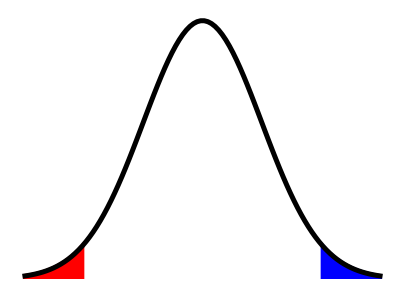

In [4]:
x = np.linspace(-3,3,100)
f = nor(0,1,x)
F = f.cumsum()

fig, ax = plt.subplots(1,1,figsize=(7,5))


#ax.plot(x,F,linewidth=5,color='k')
ax.plot(x,f,linewidth=5,color='k')
ax.set_ylim(0,.42)
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off');


xld = 2
xder=x[x>xld]
tder=f[x>xld]
xd=np.append(xder,np.array([xder[-1],xder[0]]))
td = np.append(tder,np.array([0,0]))

xli = -xld
xizq=x[x<xli]
tizq=f[x<xli]
xi=np.append(xizq,np.array([xizq[-1],xizq[0]]))
ti = np.append(tizq,np.array([0,0]))


plt.fill(xd,td,linewidth=4,color='b')
plt.fill(xi,ti,linewidth=4,color='r')



# EVA: aproximación por bloques

## Representación de las tres familias de funciones:

Se puede calcular la función de distribución de probabilidad con genextreme.pdf de stats de scipy que implementa  
GEV:

> $G(z) = exp\left \{ - \left [1+  \xi\left (  \frac{z-\mu}{\sigma}\right )\right] ^{-1/\xi}\right \}$  

pero con cuidado porque el parámetro $\xi$ en esa función tiene definido el signo al revés que en las trasparencias
y el libro de Coles (2001) en el que me he basado.   
También se pueden usar las funciones definidas más arriba GEV (normalizada con $\mu=0$ y $\sigma=1$) o GEVms, donde se calcula la función de densidad de probabilidad de GEV.

<ipython-input-2-085bb6d4cd13>:22: RuntimeWarning: invalid value encountered in power
  g = ( np.power( 1 + c * y , -1-1/c) ) * np.exp( - np.power(1 + c * y ,-1/c) ) / s


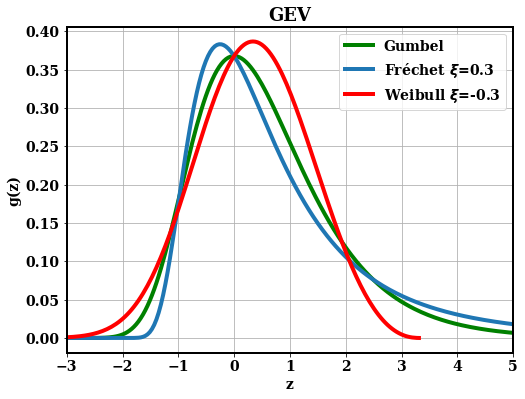

In [5]:
#Generamos las funciones de probabilidad de GEV: (¡Cuidado que el parámetro de forma tiene el signo
# cambiado con respecto al Coles (2001) y a las trasparencias en genextreme de stats de scipy!)
fig, ax = plt.subplots(1, 1, figsize=(8,6))

c = 0.3

x1, x2 = -3, 5
ax.set_xlim(x1,x2)
xx = np.linspace(x1,x2,200)
ax.plot(xx,GEVms(xx,0,0,1),'g',label='Gumbel',linewidth=4)
ax.plot(xx,GEVms(xx,c,0,1),label=r'Fréchet $\xi$='+str(c),linewidth=4)
ax.plot(xx,GEVms(xx,-c,0,1),'r',label=r'Weibull $\xi$=-'+str(c),linewidth=4)
#ax.plot(xx,stats.genextreme.pdf(xx,0),'g',label='Gumbel',linewidth=4)
#ax.plot(xx,stats.genextreme.pdf(xx,-c),label=r'Fréchet $\xi$='+str(c),linewidth=4)
#ax.plot(xx,stats.genextreme.pdf(xx,c),'r',label=r'Weibull $\xi$=-'+str(c),linewidth=4)
ax.grid()
ax.legend()
ax.set_ylabel('g(z)')
ax.set_xlabel('z')
ax.set_title('GEV')

g = GEV(x, c)

### Veamos la función de distribución

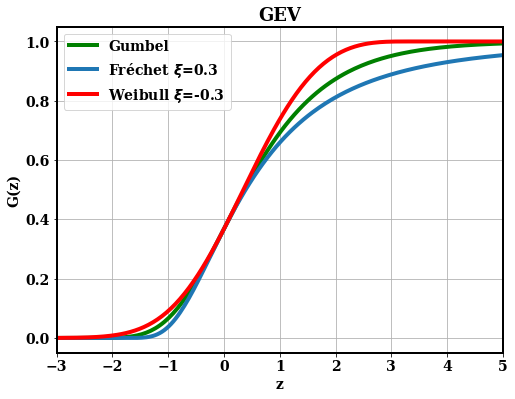

In [6]:
#Generamos las funciones de probabilidad de GEV: (¡Cuidado que el parámetro de forma tiene el signo
# cambiado con respecto al Coles (2001) y a las trasparencias en genextreme de stats de scipy!)
fig, ax = plt.subplots(1, 1, figsize=(8,6))

c = 0.3

x1, x2 = -3, 5
ax.set_xlim(x1,x2)
xx = np.linspace(x1,x2,200)
ax.plot(xx,stats.genextreme.cdf(xx,0),'g',label='Gumbel',linewidth=4)
ax.plot(xx,stats.genextreme.cdf(xx,-c),label=r'Fréchet $\xi$='+str(c),linewidth=4)
ax.plot(xx,stats.genextreme.cdf(xx,c),'r',label=r'Weibull $\xi$=-'+str(c),linewidth=4)
ax.grid()
ax.legend()
ax.set_ylabel('G(z)')
ax.set_xlabel('z')
ax.set_title('GEV');

## Ejemplo: Valores máximos anuales de nivel del mar en Port Pirie (Coles 2001)

**1. Cargamos los datos y los representamos**

Text(0.5, 0.98, 'Max. annual sea level Port Pirie')

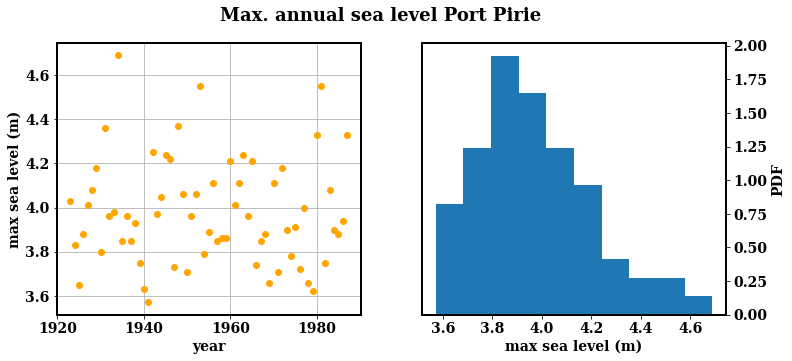

In [7]:
seaLevel = np.array([ 4.03,  3.83,  3.65,  3.88,  4.01,  4.08,  4.18,  3.8 ,  4.36,  3.96,  3.98,  4.69,\
  3.85,  3.96,  3.85,  3.93,  3.75,  3.63,  3.57,  4.25,  3.97,  4.05,  4.24,  4.22,\
  3.73,  4.37,  4.06,  3.71,  3.96,  4.06,  4.55,  3.79,  3.89,  4.11,  3.85,  3.86,\
  3.86,  4.21,  4.01,  4.11,  4.24,  3.96,  4.21,  3.74,  3.85,  3.88,  3.66,  4.11,\
  3.71,  4.18,  3.9 ,  3.78,  3.91,  3.72,  4.  ,  3.66,  3.62,  4.33,  4.55,  3.75,\
  4.08,  3.9 ,  3.88,  3.94,  4.33])

time = np.arange(1923,1988)
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].plot(time,seaLevel,'o',color='orange')
ax[0].set_ylabel('max sea level (m)')
ax[0].set_xlabel('year')
ax[0].grid()
ax[1].hist(seaLevel,density=True)
ax[1].set_xlabel('max sea level (m)')
ax[1].set_ylabel('PDF')
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")

fig.suptitle('Max. annual sea level Port Pirie',weight='bold',fontsize=18)



**2. Ajustamos los datos empleando máxima verosimilitud**

Usamos el paquete stats de scipy, que tiene genextreme.fit que hace esto

In [8]:
#Ajuste usando herramienta de scipy:
x = seaLevel.copy()
c, m, s = stats.genextreme.fit(x)
c = - c
print('MLE ='+'%.3f'%(MLE_GEV(c,m,s,x)))
print('c='+'%.3f'%(c))
print('m='+'%.3f'%(m))
print('s='+'%.3f'%(s))

MLE =-4.339
c=-0.050
m=3.875
s=0.198


**3. Usamos los parámetros ajustados a GEV para obtener el valor de retorno para 100 años**

In [9]:
print('100yr return value = '+'%.3f'%(returnLevel(0.01,c,m,s)))

100yr return value = 4.688


**4. Evaluamos la bondad del ajuste realizado (goodness of fit)**

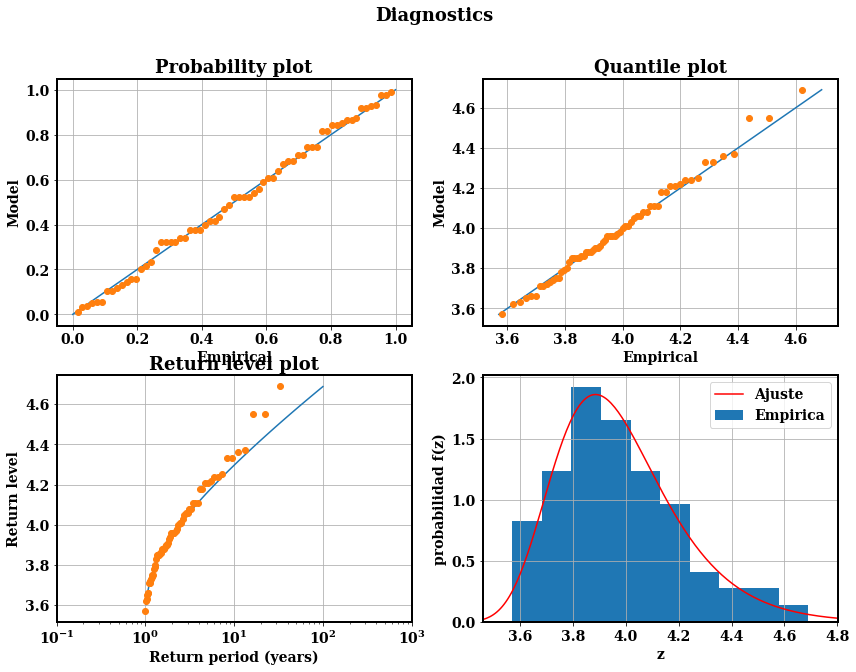

In [10]:
diagnosticsGEV(x,c,m,s)

# Extremos por umbrales: distribución generalizada de Pareto (GPD)

## Representación de las tres familias de funciones:

Se puede calcular la función de distribución de probabilidad con genpareto.pdf de stats de scipy que implementa  
GPD:

> $H(y) =  1-\left ( 1+\frac{\xi y}{\tilde {\sigma}} \right ) ^{-1/ \xi}\text{ ,  } \xi \ne 0$  
>
> $H(y) =  1-exp\left (-\frac{y}{\tilde{\sigma}} \right ) \text{ ,  } \xi = 0 $


<ipython-input-2-085bb6d4cd13>:30: RuntimeWarning: invalid value encountered in power
  h = (1/s) * ( 1 + c * y / s) ** (-1-1/c)


Text(0.5, 0.98, 'GPD')

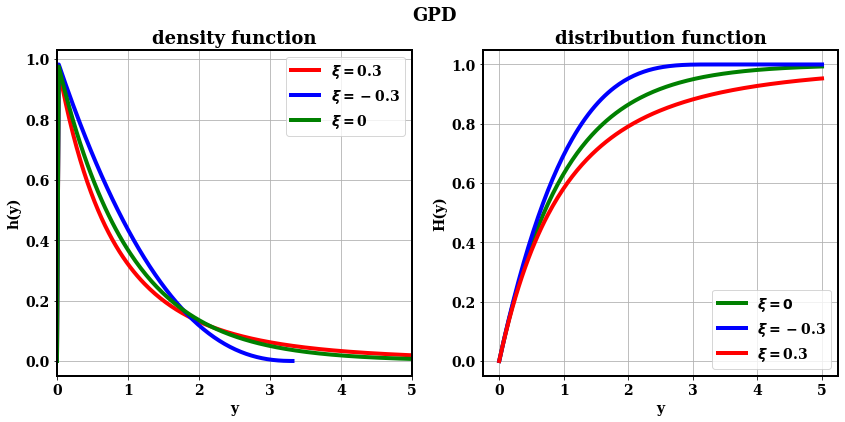

In [11]:
#Generamos las funciones de densidad de probabilidad y de distribución de GPD:
fig, ax = plt.subplots(1, 2, figsize=(14,6))

c = 0.3

x1, x2 = 0, 5
ax[0].set_xlim(x1,x2)
xx = np.linspace(x1,x2,200)
#ax.plot(xx,stats.genpareto.pdf(xx,0,0,1),'g',label=r'$\xi=0$',linewidth=4)
#ax.plot(xx,stats.genpareto.pdf(xx,-c,0,1),'b',label=r'$\xi=-$'+str(c),linewidth=4)
#ax.plot(xx,stats.genpareto.pdf(xx,c,0,1),'r',label=r'$\xi=$'+str(c),linewidth=4)
ax[0].plot(xx,GPDs(xx,c,1),'r',label=r'$\xi=$'+str(c),linewidth=4)
ax[0].plot(xx,GPDs(xx,-c,1),'b',label=r'$\xi=-$'+str(c),linewidth=4)
ax[0].plot(xx,GPDs(xx,0,1),'g',label=r'$\xi=$0',linewidth=4)
ax[0].grid()
ax[0].legend()
ax[0].set_ylabel('h(y)')
ax[0].set_xlabel('y')
ax[0].set_title('density function');

ax[1].plot(xx,stats.genpareto.cdf(xx,0,0,1),'g',label=r'$\xi=0$',linewidth=4)
ax[1].plot(xx,stats.genpareto.cdf(xx,-c,0,1),'b',label=r'$\xi=-$'+str(c),linewidth=4)
ax[1].plot(xx,stats.genpareto.cdf(xx,c,0,1),'r',label=r'$\xi=$'+str(c),linewidth=4)
ax[1].grid()
ax[1].legend()
ax[1].set_ylabel('H(y)')
ax[1].set_xlabel('y')
ax[1].set_title('distribution function');
fig.suptitle('GPD',fontsize=18,weight='bold')


## Ejemplo: Valores máximos anuales de nivel del mar en Port Pirie (Coles 2001)

**1. Cargamos los datos y los representamos**

In [12]:
#stationName='BARAJAS'
stationName='BARCELONA'
df = readDataFrame(stationName)
var = np.array(df['temp'])/10
time = df.index.to_numpy()
numYears = 47

Seleccionada la estacion BARCELONA con código 081810-99999


Text(0.5, 0.98, 'BARCELONA')

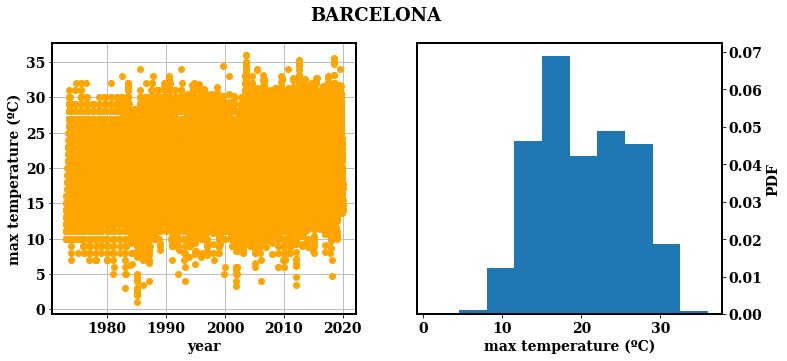

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].plot(time,var,'o',color='orange')
ax[0].set_ylabel('max temperature (ºC)')
ax[0].set_xlabel('year')
ax[0].grid()
ax[1].hist(var,density=True)
ax[1].set_xlabel('max temperature (ºC)')
ax[1].set_ylabel('PDF')
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")

fig.suptitle(stationName,weight='bold',fontsize=18)


**2. Ajustamos los datos empleando máxima verosimilitud**

+ Elegimos el umbral y seleccionamos los datos que lo superan

+ Ajustamos a la función de GPD. Usamos el paquete stats de scipy, que tiene genpareto.fit que hace esto  
  Imponemos la localización fija como umbral

/home/emohino/anaconda3/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:2432: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/home/emohino/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1063: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/home/emohino/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


c=-0.223
m=31.250
s=1.548
u=31.250
100yr-return value=36.302


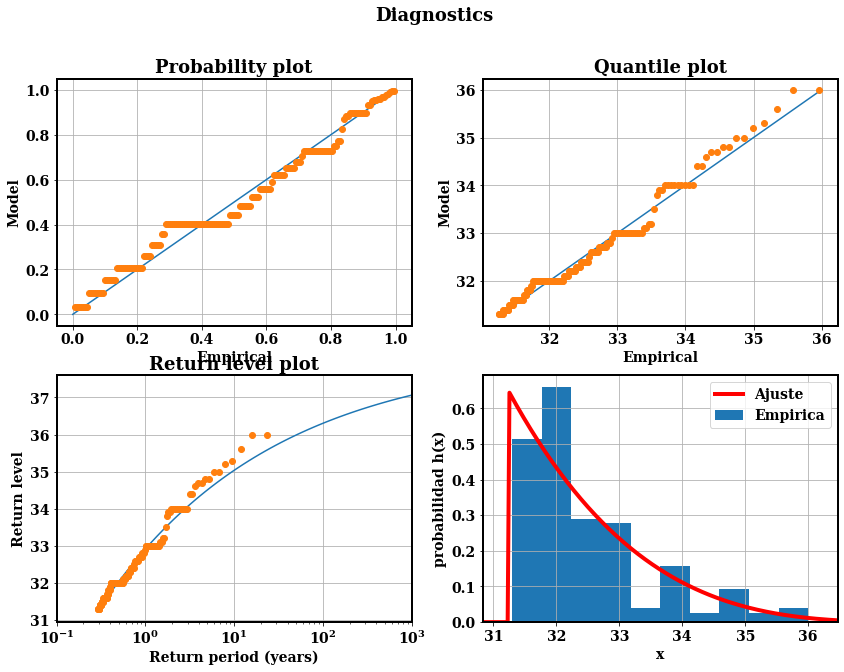

In [14]:
#Seleccion del umbral: cogeremos el percentil 95
x = var.copy()
xSort = np.sort(x)
pExp = np.arange(1,xSort.size+1,1)/(xSort.size+1)
xLess= xSort[pExp<=.99]
u = xLess[-1] +.05
yExt = x[x>u].copy()  
#Ajuste usando herramienta de scipy:
c, m, s = stats.genpareto.fit(yExt,floc = u)


N = 100;
fac = yExt.size/numYears
rv = stats.genpareto(c,m,s)
zp = rv.ppf(1-1/N/fac)

#Diagnóstico:
diagnosticsGPD(yExt,c,m,s,numYears)
print('c='+'%.3f'%(c))
print('m='+'%.3f'%(m))
print('s='+'%.3f'%(s))
print('u='+'%.3f'%(u))
print('100yr-return value='+'%.3f'%(zp))
